# Importation des librairies et des données

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
%matplotlib inline
import os
from os import listdir
from sklearn import cluster, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from plot_keras_history import show_history, plot_history

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [9]:
df_image = pd.read_csv('data.csv')

In [10]:
df_image

,image,main_category,label
0,..\Projet_6\Images\55b85ea15a1536d46b7190ad6ff...,Home Furnishing,4
1,..\Projet_6\Images\7b72c92c2f6c40268628ec5f14c...,Baby Care,0
2,..\Projet_6\Images\64d5d4a258243731dc7bbb1eef4...,Baby Care,0
3,..\Projet_6\Images\d4684dcdc759dd9cdf41504698d...,Home Furnishing,4
4,..\Projet_6\Images\6325b6870c54cd47be6ebfbffa6...,Home Furnishing,4
...,...,...,...
1045,..\Projet_6\Images\958f54f4c46b53c8a0a9b8167d9...,Baby Care,0
1046,..\Projet_6\Images\fd6cbcc22efb6b761bd564c2892...,Baby Care,0
1047,..\Projet_6\Images\5912e037d12774bb73a2048f35a...,Baby Care,0
1048,..\Projet_6\Images\c3edc504d1b4f0ba6224fa53a43...,Baby Care,0


Nous produierons dans ce Notebook deux approches basées sur la data augmentation : 
- La première par Data Generator
- La deuxième par Dataset 

# Approche par Data Generator

In [18]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

In [19]:
# Pour mélanger les images, classées initalement par classe
data = df_image.sample(frac=1, random_state=42).reset_index(drop=True)

In [20]:
batch_size = 32

def data_flow_fct(data, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(
        #DataFrame
        data, 
        #Répertoire du dossier des images
        directory='',
        #Nom de la colonne répertoriant l'adresse des images dans le Df
        x_col='image', 
        #Nom de la colonne répertoriant le label de chacune des images
        y_col='main_category',
        #Poids égaux entre les données de train
        weight_col=None,
        #Tailles de redimensions des images lors de l'entrée dans le modèle
        target_size=(256, 256),
        #Classes spécifiées dans 'main_category'
        classes=None,
        #One Hot encoding sur les labels pour le traitement
        class_mode='categorical',
        #Tailles des mini lots utilisées lors de l'entrainement
        batch_size=batch_size,
        #Mélange aléatoires des données avant chaque époque
        shuffle=True, seed=42,
        #Valeur à spécifiée : Training ou Test
        subset=data_type
                                )
    return data_flow

In [21]:
datagen_train = ImageDataGenerator(
#    featurewise_center=True,
#    featurewise_std_normalization=True,
    
    #Rotation sur une plage de +- 20 degrés
    rotation_range=20,
    
    #Décalage horizontal allant jusqu'à 20% de la taille
    width_shift_range=0.2,
    
    #Décalage vertical allant jusqu'à 20% de la taille
    height_shift_range=0.2,
    
    #Les images peuvent être retournées horizontalement de manière aléatoire
    horizontal_flip=True,
    
    #20% du set pour la validation
    validation_split=0.20,
    
    #Fonction de preprocessing des images de tensorflow
    preprocessing_function=preprocess_input)

train_flow = data_flow_fct(data, datagen_train, data_type='training')
val_flow = data_flow_fct(data, datagen_train, data_type='validation')

#datagen_test = ImageDataGenerator(
    #validation_split=0,
    #preprocessing_function=preprocess_input)

#test_flow = data_flow_fct(data_test, datagen_test, data_type=None)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
# datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:

Found 840 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.


In [22]:
# Création du modèle
with tf.device('/gpu:0'): 
    model2 = create_model_fct()

# Création du callback
model2_save_path = "./model2_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [23]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [24]:
with tf.device('/gpu:0'): 
    history2 = model2.fit(train_flow,
                    validation_data=val_flow,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)


Epoch 1/50
27/27 [==============================] - ETA: 0s - loss: 3.3516 - accuracy: 0.5048

C:\Users\nessi\anaconda3\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 1: val_loss improved from inf to 1.11939, saving model to .\model2_best_weights.h5
27/27 [==============================] - 111s 4s/step - loss: 3.3516 - accuracy: 0.5048 - val_loss: 1.1194 - val_accuracy: 0.7381
Epoch 2/50


C:\Users\nessi\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - ETA: 0s - loss: 1.4482 - accuracy: 0.6929
Epoch 2: val_loss improved from 1.11939 to 0.79213, saving model to .\model2_best_weights.h5
27/27 [==============================] - 113s 4s/step - loss: 1.4482 - accuracy: 0.6929 - val_loss: 0.7921 - val_accuracy: 0.7762
Epoch 3/50
27/27 [==============================] - ETA: 0s - loss: 1.0428 - accuracy: 0.7298
Epoch 3: val_loss did not improve from 0.79213
27/27 [==============================] - 115s 4s/step - loss: 1.0428 - accuracy: 0.7298 - val_loss: 0.8426 - val_accuracy: 0.7810
Epoch 4/50
27/27 [==============================] - ETA: 0s - loss: 0.7434 - accuracy: 0.7893
Epoch 4: val_loss improved from 0.79213 to 0.72072, saving model to .\model2_best_weights.h5
27/27 [==============================] - 114s 4s/step - loss: 0.7434 - accuracy: 0.7893 - val_loss: 0.7207 - val_accuracy: 0.8190
Epoch 5/50
27/27 [==============================] - ETA: 0s - loss: 0.5753 - accuracy: 0.8179
Epoch 5: val

In [25]:
# Score du dernier epoch

loss, accuracy = model2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

27/27 [==============================] - 90s 3s/step - loss: 0.0853 - accuracy: 0.9702
Training Accuracy   : 0.9702

7/7 [==============================] - 23s 3s/step - loss: 0.7398 - accuracy: 0.8429
Validation Accuracy :  0.8429


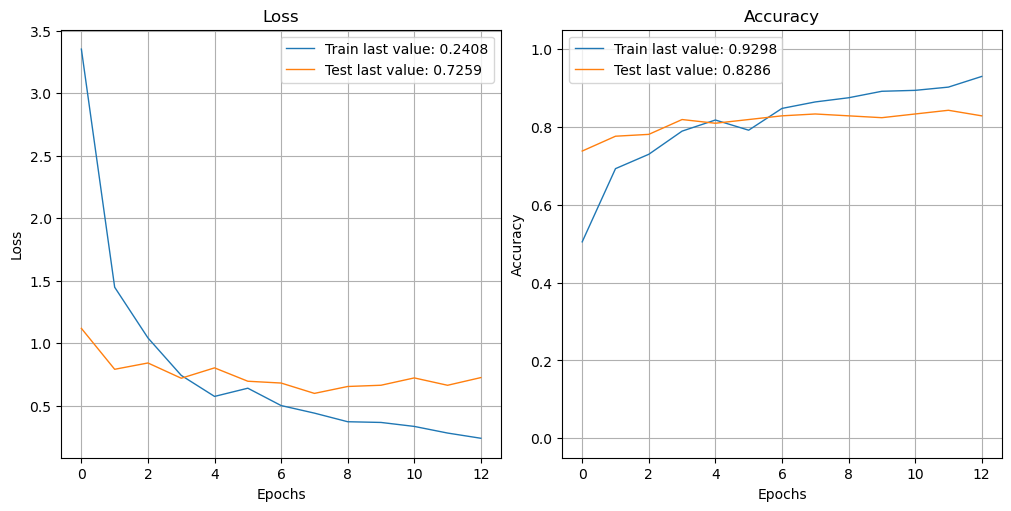

In [26]:
show_history(history2)
plot_history(history2, path="standard.png")
plt.close()

On observe que la précision du modèle sur le data test est de 0.83 ce qui est un très bon résultat pour le peu de photo présente.

# Approche par Dataset avec data augmentation intégrée au modèle

In [27]:
#Copie de df_image dans df_image_2
df_image_2 = df_image.copy()

In [28]:
#Fonction qui permet d'attribuer un nouveau chemin pour les images
def change_repertory(path):
    return path[:12] + 'Images_categ' + path[18:]

In [29]:
#Application de la fonction
df_image_2['image'] = df_image['image'].apply(change_repertory)

In [30]:
# Chemin du répertoire contenant les images
chemin_repertoire_images = "..\Projet_6\Images_categ\\"

# Créer un dictionnaire où les clés sont les noms de catégories
# et les valeurs sont les noms des sous-dossiers correspondants
categories = {
    "Home Furnishing": "Home Furnishing",
    "Baby Care": "Baby Care",
    "Watches": "Watches",
    "Home Decor & Festive Needs": "Home Decor & Festive Needs",
    "Kitchen & Dining": "Kitchen & Dining",
    "Beauty and Personal Care": "Beauty and Personal Care",
    "Computers": "Computers"
}

for fichier in df_image_2.image.values:
    if os.path.isfile(fichier):
        categorie_trouvee = df_image_2.loc[df_image_2.image == fichier, 'main_category'].values[0]
        print(categorie_trouvee)
        chemin_nouveau_dossier = os.path.join(chemin_repertoire_images, categories[categorie_trouvee])
        print(chemin_nouveau_dossier)
        os.makedirs(chemin_nouveau_dossier, exist_ok=True) # Créer le sous-dossier s'il n'existe pas déjà
        chemin_nouveau_fichier = os.path.join(chemin_nouveau_dossier, fichier[26:])
        print(chemin_nouveau_fichier)
        shutil.move(fichier, chemin_nouveau_fichier)

In [31]:
path = "..\Projet_6\Images_categ\\"

In [32]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
        #Chemin du répertoire contenant les images
        path,
        #Les labels corresponderont aux sous dossiers contenant les différentes catégories
        labels='inferred',
        #One Hot encoding sur les labels pour le traitement
        label_mode='categorical',
        #Nom des classes attribuées aux noms des sous repertoires 
        class_names=None,
        #Nombre de batch
        batch_size=batch_size,
        #Taille de redimension des images avant entrée dans le modèle
        image_size=(224, 224),
        #Mélange aléatoire pour chaque époque
        shuffle=True, seed=42,
        #Taille du validation set
        validation_split=validation_split,
        #Data train ou data validation
        subset=data_type
                    )
    return dataset

In [33]:
dataset_train = dataset_fct(path, validation_split=0.2, data_type='training')
dataset_val = dataset_fct(path, validation_split=0.2, data_type='validation')
#dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

Found 1050 files belonging to 7 classes.
Using 840 files for training.
Found 1050 files belonging to 7 classes.
Using 210 files for validation.


In [34]:
def resize_and_rescale(image, label):
    #Conversion des valeurs pixels des images en float
    image = tf.cast(image, tf.float32)
    #Redimensionne l'image à la taille spécifiée
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    #Normalisation des valeurs des pixels
    image = (image / 255.0)
    return image, label

In [35]:
def create_model_fct2() :
    # Data augmentation
    data_augmentation = Sequential([
        #Retournement horizontal aléatoire avec une proba de 0.5
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        #Rotation aléatoire de +-10% de l'image initiale
        RandomRotation(0.1),
        #Zoom aléatoire sur une plage de +-10%
        RandomZoom(0.1),
        # Rescaling(1./127.5, offset=-1.0)
      ])
    
    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                #Application de la data augmentation 
                data_augmentation,
                #Rescaling
                Rescaling(1./127.5, offset=-1),
                #VGG16
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax')
                ])

    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

In [36]:
# Création du modèle
with tf.device('/gpu:0'): 
    model4 = create_model_fct2()

# Création du callback
model4_save_path = "./model4_best_weights.h5"
checkpoint = ModelCheckpoint(model4_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_2  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                      

In [37]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [38]:
with tf.device('/gpu:0'): 
    history4 = model4.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)


Epoch 1/50
27/27 [==============================] - ETA: 0s - loss: 1.8055 - accuracy: 0.3000
Epoch 1: val_loss improved from inf to 1.34427, saving model to .\model4_best_weights.h5
27/27 [==============================] - 86s 3s/step - loss: 1.8055 - accuracy: 0.3000 - val_loss: 1.3443 - val_accuracy: 0.6143
Epoch 2/50
27/27 [==============================] - ETA: 0s - loss: 1.2916 - accuracy: 0.5667
Epoch 2: val_loss improved from 1.34427 to 1.04106, saving model to .\model4_best_weights.h5
27/27 [==============================] - 87s 3s/step - loss: 1.2916 - accuracy: 0.5667 - val_loss: 1.0411 - val_accuracy: 0.7095
Epoch 3/50
27/27 [==============================] - ETA: 0s - loss: 1.1074 - accuracy: 0.6310
Epoch 3: val_loss improved from 1.04106 to 0.90778, saving model to .\model4_best_weights.h5
27/27 [==============================] - 86s 3s/step - loss: 1.1074 - accuracy: 0.6310 - val_loss: 0.9078 - val_accuracy: 0.7333
Epoch 4/50
27/27 [==============================] - ETA:

In [39]:
# Score du dernier epoch

loss, accuracy = model4.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model4.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

27/27 [==============================] - 69s 3s/step - loss: 0.2523 - accuracy: 0.9202
Training Accuracy   : 0.9202

7/7 [==============================] - 17s 2s/step - loss: 0.5926 - accuracy: 0.8095
Validation Accuracy :  0.8095


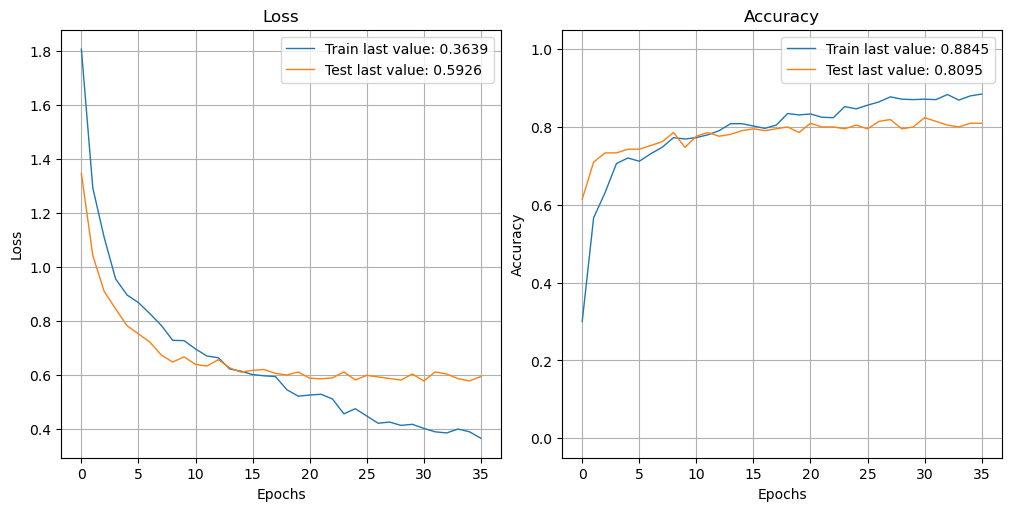

In [40]:
show_history(history4)
plot_history(history4, path="standard.png")
plt.close()

On voit que sur le test set l'accuracy est de 0.81, cela reste très correct.